**HOMEWORK 11**

---



---


In this homework you are going to improve the DNN for house price estimation we built during the lesson. The objective is to beat the performance (i.e. to get a closer estimation) of the last network we built in the lecture.

The structure of this homework is as follows:


*   First, we are going to build the reference network (exactly the same network we implemented in the lecture).
*   You are going to run it a write down the price estimation error (Validation MAE).
*   Then you are going to make some modifications in order to make the network perform better.
*   In the section Tasks you will find what modification you'll need to implement as well as some hints.

At the end, as usual, there are some question waiting for you to answer :-)

In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# from tensorflow.keras import Model, metrics
from tensorflow import keras, random
from tensorflow import random as rnd
from keras import Model, metrics
#from tensorflow.keras.layers import Dense, Dropout, Input
from keras.layers import Dense, Dropout, Input
# Set the seeds
from numpy.random import seed
import copy
#from random import set_seed

**Data Preparation**

Let's load the data and prepare the training sets.

In [2]:
dataset = pd.read_csv('/content/drive/MyDrive/CV_HW_11/train.csv')
# get data description
print(f'data shape is: {dataset.shape}\n')
print(f'data general info is:\n{dataset.info()}')
dataset.head(5)
# dataset.tail(5)

data shape is: (1460, 81)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-n

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Let's use the same plotting helper we used in the lecture.

In [3]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, np.array(h['mean_absolute_error'])*1e5, '.-',
                               epochs, np.array(h['val_mean_absolute_error'])*1e5, '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'])
        
    print('Train MAE     ', h['mean_absolute_error'][-1]*1e5)
    print('Validation MAE', h['val_mean_absolute_error'][-1]*1e5)

In [7]:
features = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']
features_with_LotArea = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt', 'LotArea']
features_with_LotArea_BedroomAbvGr = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', \
                                      'YearBuilt', 'LotArea', 'BedroomAbvGr']
features_with_LotArea_BedroomAbvGr_KitchenAbvGr = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', \
                                                   'YearBuilt', 'LotArea', 'BedroomAbvGr', 'KitchenAbvGr']
features_with_LotArea_BedroomAbvGr_KitchenAbvGr_Fireplaces = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', \
                                                              'FullBath','YearBuilt', 'LotArea', 'BedroomAbvGr', \
                                                              'KitchenAbvGr', 'Fireplaces']
features_with_LotArea_BedroomAbvGr_KitchenAbvGr_Fireplaces_OverallCond = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', \
                                                                          'FullBath','YearBuilt', 'LotArea', 'BedroomAbvGr', \
                                                                          'KitchenAbvGr', 'Fireplaces', 'OverallCond']


set_of_features = [features, \
                   features_with_LotArea, \
                   features_with_LotArea_BedroomAbvGr, \
                   features_with_LotArea_BedroomAbvGr_KitchenAbvGr, \
                   features_with_LotArea_BedroomAbvGr_KitchenAbvGr_Fireplaces, \
                   features_with_LotArea_BedroomAbvGr_KitchenAbvGr_Fireplaces_OverallCond]

set_of_histories, set_of_histories_2x_num_of_neurons, set_of_histories_adamax_optimizer = [], [], []

def data_generator(buffer_to_save_data, mult_factor_of_neurons = 1, optimizer_to_test = 'adam'):
    for idx in range(len(set_of_features)):
        # for reproducibility reasons
        seed_value = 1234578790
        seed(seed_value)
        rnd.set_seed(seed_value)

        data = dataset[set_of_features[idx]]

        # Filling nan with the mean of the column:
        data = data.fillna(data.mean())

        # Extract input values and normalize
        x = data[set_of_features[idx][1:]]
        scale = StandardScaler()
        x = scale.fit_transform(x)

        # Extract output values (prices) and normalize
        y = data[set_of_features[idx][0]].values
        y = y/100000

        # Split into 75% for train and 25% for test
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=seed_value)

        # Building the Network
        inputs = Input(shape=x.shape[1])
        outputs = Dense((len(set_of_features[idx])-1)*mult_factor_of_neurons, activation='relu')(inputs)
        outputs = Dense(1, activation='linear')(outputs)
        model = Model(inputs, outputs)

        model.compile(optimizer = optimizer_to_test, loss ='mean_squared_error', metrics =[metrics.mae])
        model.summary()
        history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=150, batch_size=32, verbose=0)
        buffer_to_save_data.append(copy.deepcopy(history))

In [8]:
data_generator(set_of_histories)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_12 (Dense)            (None, 5)                 30        
                                                                 
 dense_13 (Dense)            (None, 1)                 6         
                                                                 
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ram://aedc3f86-36db-4f79-986e-40033703b7bd/assets
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 6)]               0         
                           

In [9]:
data_generator(set_of_histories_adamax_optimizer, optimizer_to_test = 'adamax')

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_24 (Dense)            (None, 5)                 30        
                                                                 
 dense_25 (Dense)            (None, 1)                 6         
                                                                 
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ram://84e403a4-1553-4703-8406-93640590b7dd/assets
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 6)]               0         
                         

In [10]:
data_generator(set_of_histories_2x_num_of_neurons, mult_factor_of_neurons = 2)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_36 (Dense)            (None, 10)                60        
                                                                 
 dense_37 (Dense)            (None, 1)                 11        
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ram://d8eee42b-996f-4505-b005-94a9153799a4/assets
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 6)]               0         
                         

In [11]:
#set_of_histories, set_of_histories_2x_num_of_neurons, set_of_histories_adamax_optimizer
print("idx", f"{' '*7}set_of_histories{' '*5}", f"{' '*9}set_of_histories_2x_num_of_neurons", f"{' '*1}set_of_histories_adamax_optimizer", f"{' '*3}N of features\n")
for idx in range(len(set_of_features)):

    val1, val2 = set_of_histories[idx].history['mean_absolute_error'][-1]*1e5, \
    set_of_histories[idx].history['val_mean_absolute_error'][-1]*1e5 # adam opt, 1x num of neurons

    val3, val4 = set_of_histories_2x_num_of_neurons[idx].history['mean_absolute_error'][-1]*1e5, \
    set_of_histories_2x_num_of_neurons[idx].history['val_mean_absolute_error'][-1]*1e5 # adam opt, 2x num of neurons

    val5, val6 = set_of_histories_adamax_optimizer[idx].history['mean_absolute_error'][-1]*1e5, \
    set_of_histories_adamax_optimizer[idx].history['val_mean_absolute_error'][-1]*1e5 # adamax opt, 1x num of neurons

    print(f"{idx:>2} | Train MAE:{int(val1):>6}  Valid MAE:{int(val2):>6} | Train MAE:{int(val3):>6}  Valid MAE:{int(val4):>6} | Train MAE:{int(val5):>6}  Valid MAE:{int(val6):>6} | {len(set_of_features[idx])-1:>4}")

idx        set_of_histories               set_of_histories_2x_num_of_neurons  set_of_histories_adamax_optimizer    N of features

 0 | Train MAE: 23051  Valid MAE: 25549 | Train MAE: 22545  Valid MAE: 24592 | Train MAE: 23769  Valid MAE: 26211 |    5
 1 | Train MAE: 21403  Valid MAE: 23426 | Train MAE: 20876  Valid MAE: 23517 | Train MAE: 23859  Valid MAE: 25206 |    6
 2 | Train MAE: 22159  Valid MAE: 25413 | Train MAE: 20610  Valid MAE: 22349 | Train MAE: 27028  Valid MAE: 28833 |    7
 3 | Train MAE: 21794  Valid MAE: 23926 | Train MAE: 19638  Valid MAE: 21544 | Train MAE: 23692  Valid MAE: 23325 |    8
 4 | Train MAE: 22205  Valid MAE: 24800 | Train MAE: 19351  Valid MAE: 22460 | Train MAE: 25530  Valid MAE: 28925 |    9
 5 | Train MAE: 18849  Valid MAE: 22937 | Train MAE: 17687  Valid MAE: 21583 | Train MAE: 22791  Valid MAE: 25257 |   10


In [43]:
print(set_of_histories[0].history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


Train MAE      17687.223851680756
Validation MAE 21583.67484807968


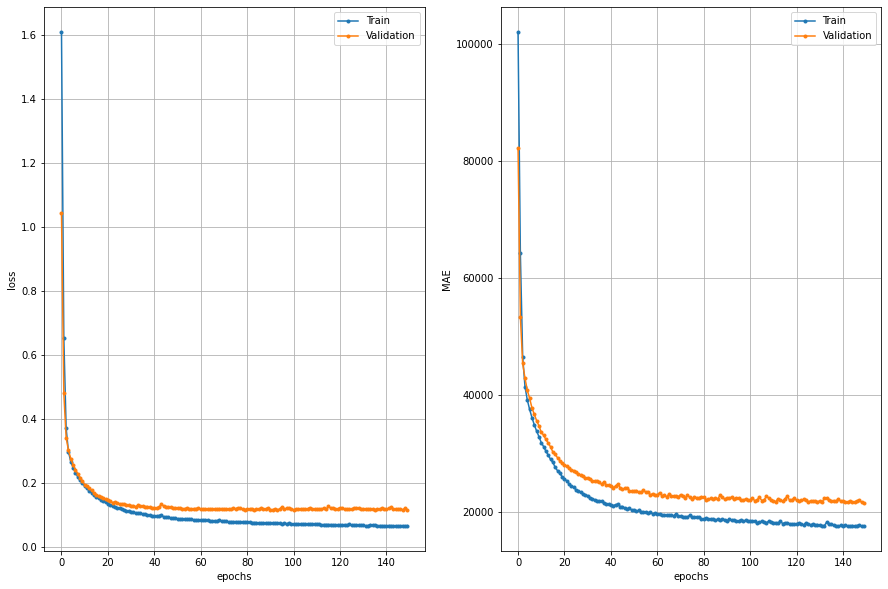

In [14]:
# best result is
plt.rcParams['figure.figsize'] = [15, 10]
plot_history(set_of_histories_2x_num_of_neurons[5])

**Tasks**

Improve the network so you obtain a better estimation error than the reference. You can try the following:

*   Add a new feature to your inputs. For instance, **`LotArea`**  (lot size in square feet) seems like a good candidate :-)
*   Try increasing the number of neurons in the first layer. Currently, we have 5 neurons there, what happens if we increase it to 10?



**Questions**

*   What is the new price estimation error after your modifrications? Is it better than before?
*   Does adding more features help?
*   Does adding more neurons help?
*   What would you do to improv the network even further?

**Answers**



*   The best result I have got is: *Train MAE*: 17687  *Valid MAE*: 21583.
Original result is: *Train MAE*: 23051  *Valid MAE*: 25549.
I made experiments with different numbers of features, neurons and another optimizer.
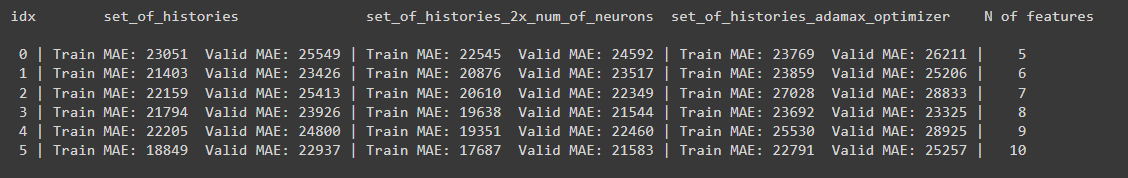




*   To get better *estimation error* I have used more features, 10 vs 5, so it helped.
*   To get better *estimation error* I have used more neurons. As a result, the best MAE is with highest num of features and neurons.
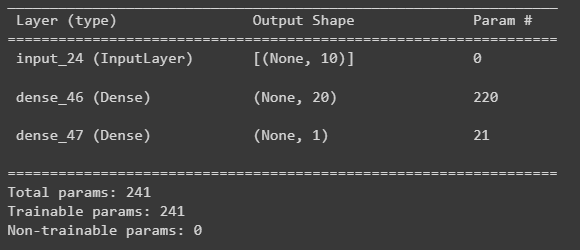



*   By me it makes sense to add another important features. I have noted, that not all newly added features make better MAE.
It is likely enough, that with higher num of features MAE will be worse. With higher num of neurons this behaviour presents less.
It is also present features, that have 'object' datatype. It is good to find all possible variants of this feature, encode with nums and add to neural network.
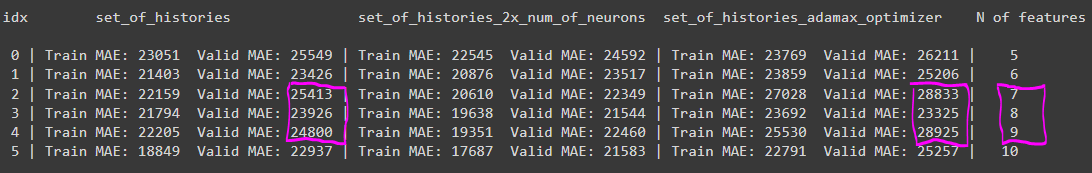

*   It is good idea to make experiments with ***type of optimizer***, ***type of activation***, ***number of layers*** and ***type of neural network***.

